# Tokenization Strategies for Bat Vocalizations

This notebook sets up three representation / tokenization strategies on top of the 10k subset (using `data/annotations.csv` and derived features):

1. **Self-supervised speech encoders (wav2vec 2.0 / HuBERT) + k-means** to produce discrete "bio-tokens".
2. **VQ-VAE on mel-spectrograms** to learn a discrete codebook of acoustic units.
3. **Continuous-feature encoders (AST)** that operate on spectrograms without discretization.

Classifier or sequence models can be trained later on top of the saved representations.

In [3]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, cast

import numpy as np
import pandas as pd
import torch
from sklearn.cluster import KMeans

ROOT = Path.cwd().resolve()  # launched kernel in starter_code/
DATA_DIR = ROOT / 'data'
DERIVED_DIR = ROOT / 'derived'
AUDIO_DIR = DATA_DIR / 'audio'
MELS_48K_DIR = DERIVED_DIR / 'mels_48k'
TOKENS_DIR = DERIVED_DIR / 'tokens'
AST_DIR = DERIVED_DIR / 'ast_features'

TOKENS_DIR.mkdir(exist_ok=True, parents=True)
AST_DIR.mkdir(exist_ok=True, parents=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE: ", device)
print("ROOT: ", ROOT)


DEVICE:  cpu
ROOT:  /Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/starter_code


## 1. wav2vec 2.0 / HuBERT embeddings + k-means clustering

Use a pretrained self-supervised speech model to get frame-level embeddings, then learn a k-means codebook to derive discrete token sequences per call.

In [ ]:
# NOTE from mahika: took about 12 min for me to run this cell
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import librosa

W2V_MODEL_NAME = 'facebook/wav2vec2-base'  # or a HuBERT variant

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(W2V_MODEL_NAME)

w2v_model: Wav2Vec2Model = Wav2Vec2Model.from_pretrained(W2V_MODEL_NAME)
w2v_model.eval()

ann_small = pd.read_csv(DATA_DIR / 'annotations.csv')

# NOTE: can change target_sr to 48_000 or something else to not downsample as much
def load_audio_for_w2v(path: Path, target_sr: int = 16_000) -> np.ndarray:
    y, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    return y.astype(np.float32)

def extract_w2v_embeddings(wav: np.ndarray, sr: int = 16_000) -> np.ndarray:
    inputs = feature_extractor(wav, sampling_rate=sr, return_tensors='pt')
    with torch.no_grad():
        out = w2v_model(inputs.input_values.to(device))
    # shape: (1, T, hidden_size)
    return out.last_hidden_state.squeeze(0).cpu().numpy()

# Example: extract embeddings for a small subset of files, or all files
subset = ann_small['File Name'].iloc[:None]
all_frames: List[np.ndarray] = []
file2frame_indices: Dict[str, slice] = {}
start = 0

for idx, fn in enumerate(subset):
    path = AUDIO_DIR / fn
    if not path.exists():
        continue
    wav = load_audio_for_w2v(path)
    emb = extract_w2v_embeddings(wav)  # (T, D)
    end = start + emb.shape[0]
    all_frames.append(emb)
    file2frame_indices[fn] = slice(start, end)
    start = end
    print(f"Processed {idx+1}/{len(subset)} files")

frame_matrix = np.concatenate(all_frames, axis=0)  # (total_T, D)
frame_matrix.shape # (931105, 768)

# 931,105: total number of time frames across all processed audio files
#       (i.e., concatenating each file’s wav2vec2 frame sequence end‑to‑end)
# 768: the embedding dimension of the wav2vec2 model
#       (facebook/wav2vec2-base outputs 768‑dimensional vectors per frame)
# So frame_matrix is a big 2D array of all frame‑level embeddings:
# each row is one frame, each column is one embedding feature.


/Users/mahikacalyanakoti/Downloads/College/Year4/Year4Sem1/ESE5460/bat-llm/.venv/lib/python3.13/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Processed 1/10000 files
Processed 2/10000 files
Processed 3/10000 files
Processed 4/10000 files
Processed 5/10000 files
Processed 6/10000 files
Processed 7/10000 files
Processed 8/10000 files
Processed 9/10000 files
Processed 10/10000 files
Processed 11/10000 files
Processed 12/10000 files
Processed 13/10000 files
Processed 14/10000 files
Processed 15/10000 files
Processed 16/10000 files
Processed 17/10000 files
Processed 18/10000 files
Processed 19/10000 files
Processed 20/10000 files
Processed 21/10000 files
Processed 22/10000 files
Processed 23/10000 files
Processed 24/10000 files
Processed 25/10000 files
Processed 26/10000 files
Processed 27/10000 files
Processed 28/10000 files
Processed 29/10000 files
Processed 30/10000 files
Processed 31/10000 files
Processed 32/10000 files
Processed 33/10000 files
Processed 34/10000 files
Processed 35/10000 files
Processed 36/10000 files
Processed 37/10000 files
Processed 38/10000 files
Processed 39/10000 files
Processed 40/10000 files
Processed

(931105, 768)

In [6]:
# Fit k-means on frame-level embeddings to create a codebook
N_CLUSTERS = 128
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
kmeans.fit(frame_matrix)

# Convert each file's frames into a sequence of discrete token IDs
file2tokens: Dict[str, np.ndarray] = {}
for idx, (fn, sl) in enumerate(file2frame_indices.items()):
    frame_embs = frame_matrix[sl]
    tokens = kmeans.predict(frame_embs)
    tokens_arr = np.asarray(tokens, dtype=np.int16)
    file2tokens[fn] = tokens_arr
    np.save(TOKENS_DIR / f'w2v_kmeans_{Path(fn).stem}.npy', tokens_arr)
    print(f"Processed {idx+1}/{len(file2frame_indices)} files")

len(file2tokens)


Processed 1/10000 files
Processed 2/10000 files
Processed 3/10000 files
Processed 4/10000 files
Processed 5/10000 files
Processed 6/10000 files
Processed 7/10000 files
Processed 8/10000 files
Processed 9/10000 files
Processed 10/10000 files
Processed 11/10000 files
Processed 12/10000 files
Processed 13/10000 files
Processed 14/10000 files
Processed 15/10000 files
Processed 16/10000 files
Processed 17/10000 files
Processed 18/10000 files
Processed 19/10000 files
Processed 20/10000 files
Processed 21/10000 files
Processed 22/10000 files
Processed 23/10000 files
Processed 24/10000 files
Processed 25/10000 files
Processed 26/10000 files
Processed 27/10000 files
Processed 28/10000 files
Processed 29/10000 files
Processed 30/10000 files
Processed 31/10000 files
Processed 32/10000 files
Processed 33/10000 files
Processed 34/10000 files
Processed 35/10000 files
Processed 36/10000 files
Processed 37/10000 files
Processed 38/10000 files
Processed 39/10000 files
Processed 40/10000 files
Processed

10000

## 2. VQ-VAE over mel-spectrograms

We now use a simple VQ-VAE model that operates on log-mel spectrogram patches loaded from `derived/mels_48k`. 

NOTE: Can tune architecture and training hyperparameters further

In [ ]:
import torch.nn as nn

class VectorQuantizer(nn.Module):
    def __init__(self, num_codes: int, code_dim: int, beta: float = 0.25):
        super().__init__()
        self.code_dim = code_dim
        self.embeddings = nn.Embedding(num_codes, code_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_codes, 1.0 / num_codes)
        self.beta = beta

    def forward(self, z: torch.Tensor):
        # z: (B, C, T, F) -> flatten to (B*T*F, C)
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, self.code_dim)
        # Compute distances to codebook
        distances = (
            flat_z.pow(2).sum(dim=1, keepdim=True)
            - 2 * flat_z @ self.embeddings.weight.t()
            + self.embeddings.weight.pow(2).sum(dim=1)
        )
        codes = distances.argmin(dim=1)
        z_q = self.embeddings(codes).view(*z_perm.shape)
        z_q = z_q.permute(0, 3, 1, 2).contiguous()
        # VQ-VAE losses
        commitment_loss = self.beta * (z_q.detach() - z).pow(2).mean()
        codebook_loss = (z_q - z.detach()).pow(2).mean()
        z_q = z + (z_q - z).detach()  # straight-through
        return z_q, codes.view(z.size(0), -1), commitment_loss + codebook_loss

class SimpleVQVAE(nn.Module):
    def __init__(self, hidden_dim: int = 128, num_codes: int = 256):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.vq = VectorQuantizer(num_codes=num_codes, code_dim=hidden_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: torch.Tensor):  # x: (B, 1, T, F)
        z = self.encoder(x)
        z_q, codes, vq_loss = self.vq(z)
        recon = self.decoder(z_q)
        recon_loss = (x - recon).pow(2).mean()
        return recon, codes, recon_loss + vq_loss


In [ ]:
# Minimal data loader for mel patches
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, mels_dir: Path, file_names: List[str]):
        self.mel_paths = [mels_dir / (Path(fn).stem + '.npy') for fn in file_names]
        self.mel_paths = [p for p in self.mel_paths if p.exists()]

    def __len__(self) -> int:
        return len(self.mel_paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        mel = np.load(self.mel_paths[idx])  # (n_mels, T)
        x = torch.from_numpy(mel.T).unsqueeze(0)  # (1, T, F)
        return x

subset_fns = ann_small['File Name'].iloc[:256].tolist()
mel_ds = MelDataset(MELS_48K_DIR, subset_fns)
mel_dl = torch.utils.data.DataLoader(mel_ds, batch_size=8, shuffle=True)

vqvae = SimpleVQVAE().to(device)
opt = torch.optim.Adam(vqvae.parameters(), lr=1e-3)

# Very small warm-up training loop (extend as needed)
for step, x in enumerate(mel_dl):
    x = x.to(device)
    recon, codes, loss = vqvae(x)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if step % 10 == 0:
        print(f'step {step}: loss={loss.item():.4f}')
    if step >= 50:  # keep short by default
        break

# Save code indices for a few examples
vq_tokens_dir = TOKENS_DIR / 'vqvae'
vq_tokens_dir.mkdir(exist_ok=True, parents=True)

vqvae.eval()
with torch.no_grad():
    for fn in subset_fns[:64]:
        mel_path = MELS_48K_DIR / (Path(fn).stem + '.npy')
        if not mel_path.exists():
            continue
        mel = np.load(mel_path).T  # (T, F)
        x = torch.from_numpy(mel).unsqueeze(0).unsqueeze(0).to(device)
        _, codes, _ = vqvae(x)
        codes_np = codes.squeeze(0).cpu().numpy().astype(np.int16)
        np.save(vq_tokens_dir / f'vqvae_{Path(fn).stem}.npy', codes_np)


## 3. Continuous representations with AST (Audio Spectrogram Transformer)

We obtain continuous embeddings from an Audio Spectrogram Transformer (AST), ex. pretrained on AudioSet.
These can be used directly for downstream classification or captioning without discretization.

In [ ]:
from transformers import AutoFeatureExtractor, ASTModel

AST_MODEL_NAME = 'MIT/ast-finetuned-audioset-10-10-0.4593'
ast_extractor = AutoFeatureExtractor.from_pretrained(AST_MODEL_NAME)

ast_model: ASTModel = ASTModel.from_pretrained(AST_MODEL_NAME)
ast_model.eval()

def load_mel_as_ast_input(mel_path: Path) -> Dict[str, torch.Tensor]:
    mel = np.load(mel_path)  # (n_mels, T)
    inputs = ast_extractor(
        mel,
        sampling_rate=48_000,  # nominal value when passing features directly
        return_tensors='pt',
    )
    return {k: v.to(device) for k, v in inputs.items()}

for fn in ann_small['File Name'].iloc[:None]:
    mel_path = MELS_48K_DIR / (Path(fn).stem + '.npy')
    if not mel_path.exists():
        continue
    inputs = load_mel_as_ast_input(mel_path)
    with torch.no_grad():
        out = ast_model(**inputs)
    pooled = out.pooler_output.squeeze(0).cpu().numpy().astype(np.float32)
    np.save(AST_DIR / f'ast_{Path(fn).stem}.npy', pooled)

len(list(AST_DIR.glob('*.npy')))


# INSPECTION:

### Inspect wav2vec k-means tokens for a few example files

The cell below loads the saved k-means token sequences for a few audio files and
shows:
- The number of frames (tokens) per file
- The most frequent token IDs
- A 1D "image" of the token sequence over time


File: 69809.wav
Num frames (tokens): 117
Top token IDs (id: count):
  72: 23
  103: 18
  30: 18
  2: 12
  61: 6
  18: 5
  70: 4
  86: 3
  85: 3
  122: 3


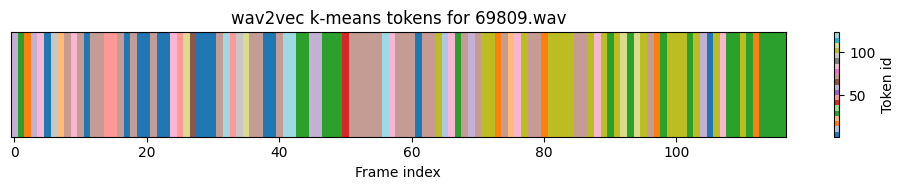


File: 71889.wav
Num frames (tokens): 65
Top token IDs (id: count):
  31: 26
  82: 10
  43: 10
  41: 8
  3: 5
  71: 2
  52: 2
  124: 1
  11: 1


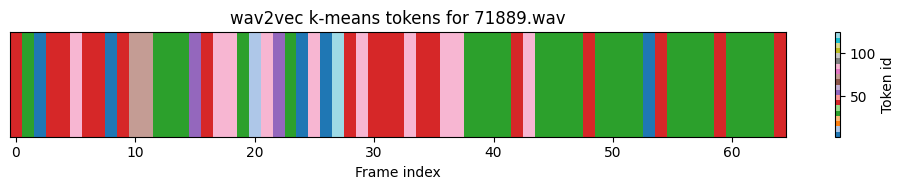


File: 46690.wav
Num frames (tokens): 93
Top token IDs (id: count):
  89: 26
  76: 26
  105: 11
  126: 8
  66: 6
  4: 5
  123: 3
  27: 3
  26: 2
  81: 1


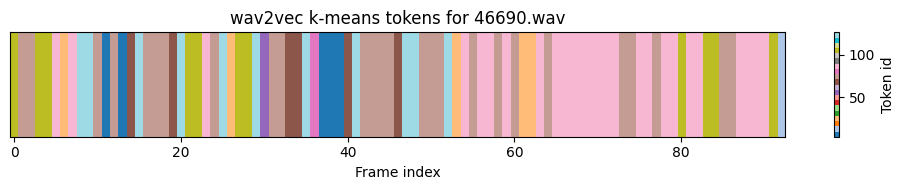

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

# Pick a few example files to inspect
sample_files = ann_small["File Name"].iloc[:3]

for fn in sample_files:
    stem = Path(fn).stem
    token_path = TOKENS_DIR / f"w2v_kmeans_{stem}.npy"
    if not token_path.exists():
        print(f"Skipping {fn}: tokens not found at {token_path}")
        continue

    tokens = np.load(token_path)

    print("\n" + "=" * 80)
    print(f"File: {fn}")
    print(f"Num frames (tokens): {len(tokens)}")

    # Show the most frequent token IDs
    uniq, counts = np.unique(tokens, return_counts=True)
    order = np.argsort(counts)[::-1]
    top_k = 10
    print("Top token IDs (id: count):")
    for i in order[:top_k]:
        print(f"  {int(uniq[i])}: {int(counts[i])}")

    # Visualize the token sequence over time as a 1D image
    plt.figure(figsize=(10, 2))
    plt.imshow(tokens[None, :], aspect="auto", interpolation="nearest", cmap="tab20")
    plt.yticks([])
    plt.xlabel("Frame index")
    plt.title(f"wav2vec k-means tokens for {fn}")
    plt.colorbar(label="Token id")
    plt.tight_layout()
    plt.show()

### Visualize wav2vec tokens aligned with the original waveform

The cell below, for a few example files:
- Loads the original waveform (resampled to 16 kHz for wav2vec2)
- Loads the saved k-means token sequence
- Plots waveform amplitude over time and the token IDs over time on a shared x-axis
- (Optionally) plays back the audio so you can listen while looking at the tokens.


File: 69809.wav
Waveform samples: 37803 at 16000 Hz (duration ~2.36s)
Num tokens: 117; token rate ~49.5 Hz


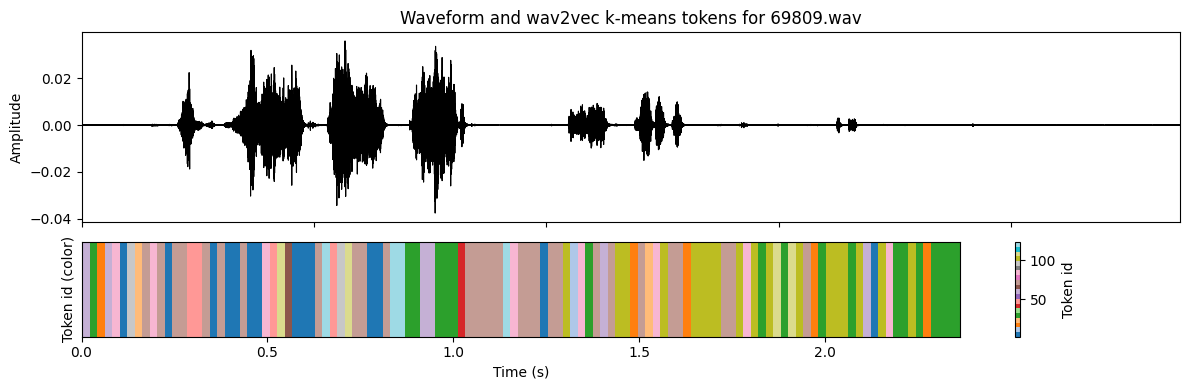


File: 71889.wav
Waveform samples: 21026 at 16000 Hz (duration ~1.31s)
Num tokens: 65; token rate ~49.5 Hz


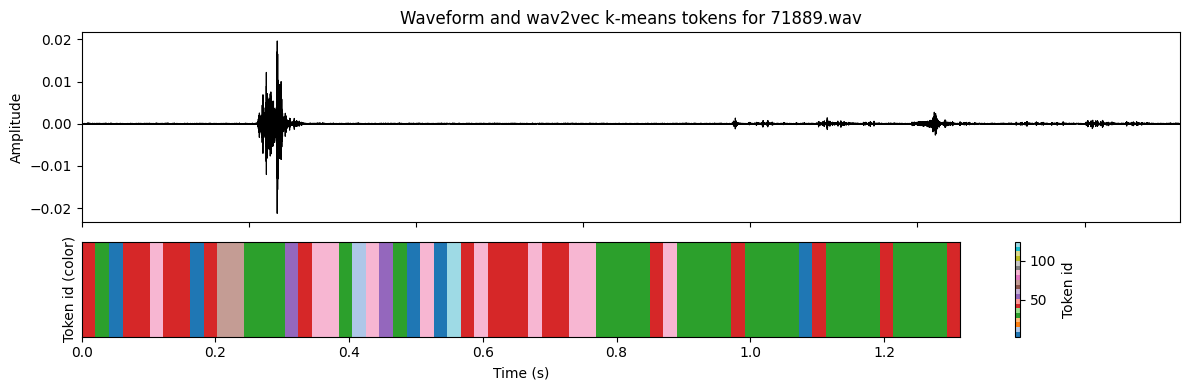


File: 46690.wav
Waveform samples: 29939 at 16000 Hz (duration ~1.87s)
Num tokens: 93; token rate ~49.7 Hz


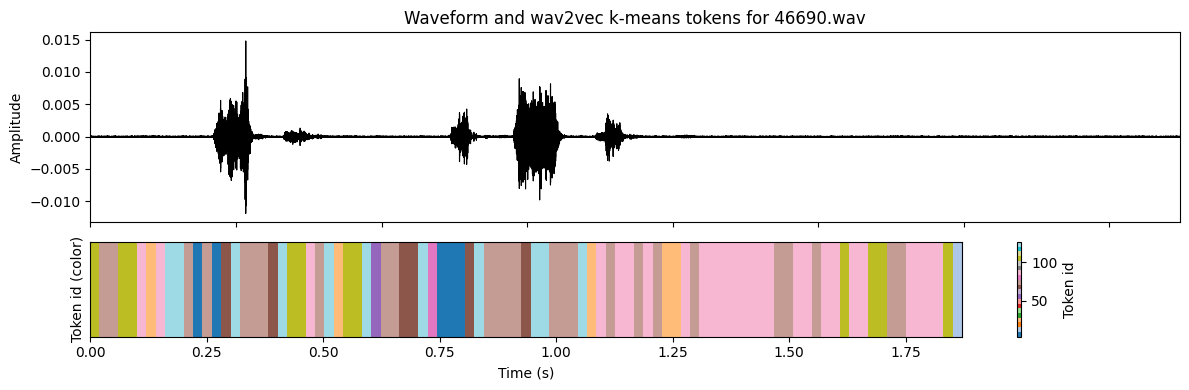

In [8]:
import IPython.display as ipd

# visualize tokens vs waveform for a single file

def plot_waveform_and_tokens(fn: str, max_duration: float | None = None) -> None:
    """Plot waveform (16 kHz) and wav2vec k-means tokens over time for one file."""
    wav_path = AUDIO_DIR / fn
    stem = Path(fn).stem
    token_path = TOKENS_DIR / f"w2v_kmeans_{stem}.npy"

    if not wav_path.exists():
        print(f"Missing audio: {wav_path}")
        return
    if not token_path.exists():
        print(f"Missing tokens: {token_path}")
        return

    # load audio in the same way we fed it to wav2vec2
    wav_16k = load_audio_for_w2v(wav_path, target_sr=16_000)
    sr = 16_000

    if max_duration is not None:
        max_samples = int(max_duration * sr)
        wav_16k = wav_16k[:max_samples]

    tokens = np.load(token_path)

    duration = len(wav_16k) / sr
    t_wave = np.linspace(0.0, duration, num=len(wav_16k))
    # spread token centers uniformly over the duration
    t_tok = np.linspace(0.0, duration, num=len(tokens))

    print(f"\nFile: {fn}")
    print(f"Waveform samples: {len(wav_16k)} at {sr} Hz (duration ~{duration:.2f}s)")
    print(f"Num tokens: {len(tokens)}; token rate ~{len(tokens)/duration:.1f} Hz")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                                   gridspec_kw={"height_ratios": [2, 1]})

    # waveform
    ax1.plot(t_wave, wav_16k, color="black", linewidth=0.8)
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Waveform and wav2vec k-means tokens for {fn}")

    # tokens as a 1D image
    im = ax2.imshow(
        tokens[None, :],
        aspect="auto",
        interpolation="nearest",
        cmap="tab20",
        extent=[0.0, duration, 0.0, 1.0],
    )
    ax2.set_yticks([])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Token id (color)")
    fig.colorbar(im, ax=ax2, label="Token id")

    plt.tight_layout()
    plt.show()


# visualize a few example files
example_files = ann_small["File Name"].iloc[:3]
for fn in example_files:
    plot_waveform_and_tokens(fn, max_duration=5.0)  # cap at 5s for readability


### Discretize frame-level tokens into chunk-level tokens (run-length compression)

The code below:
- Takes the per-frame wav2vec k-means tokens for a file.
- Collapses consecutive identical tokens into **chunks** (run-length encoding).
- Plots the 16 kHz waveform and these chunk-level tokens over time so that
  the number of color blocks is closer to the number of perceptual chunks in the audio.


File: 69809.wav
Waveform samples: 37803 at 16000 Hz (duration ~2.36s)
Frame-level tokens: 117
Chunk-level tokens after compression: 90


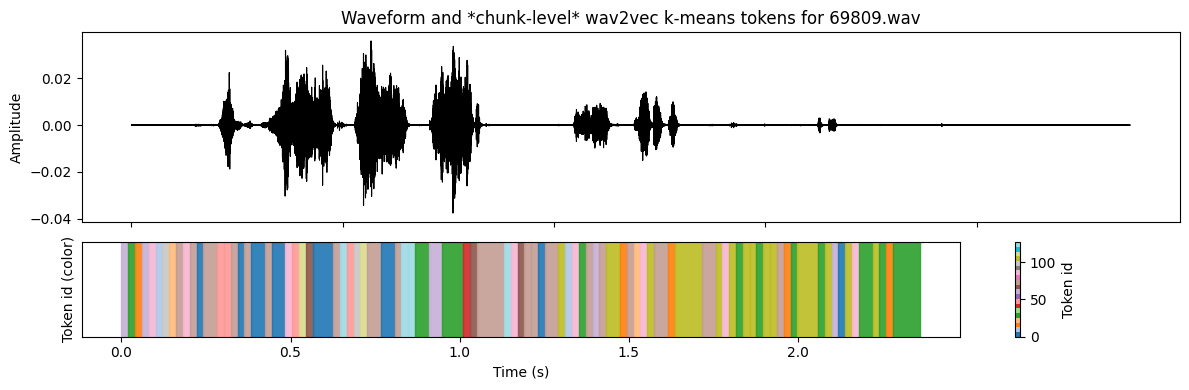


File: 71889.wav
Waveform samples: 21026 at 16000 Hz (duration ~1.31s)
Frame-level tokens: 65
Chunk-level tokens after compression: 44


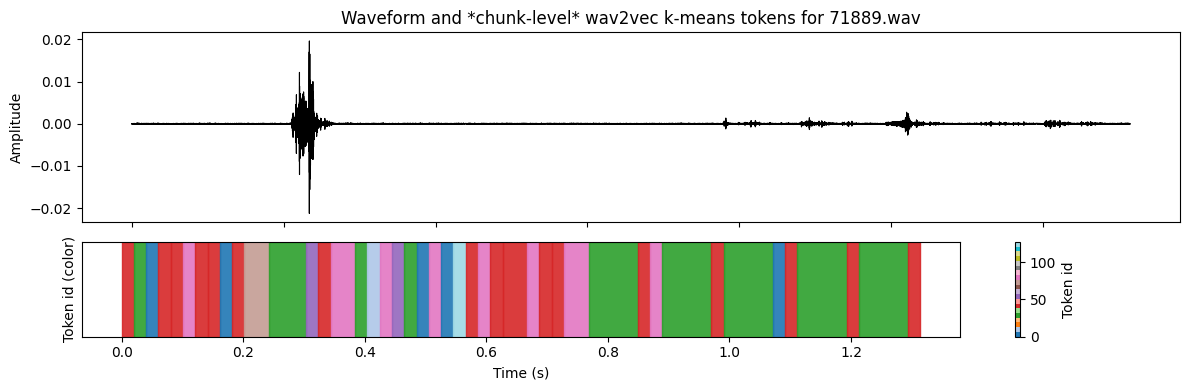


File: 46690.wav
Waveform samples: 29939 at 16000 Hz (duration ~1.87s)
Frame-level tokens: 93
Chunk-level tokens after compression: 59


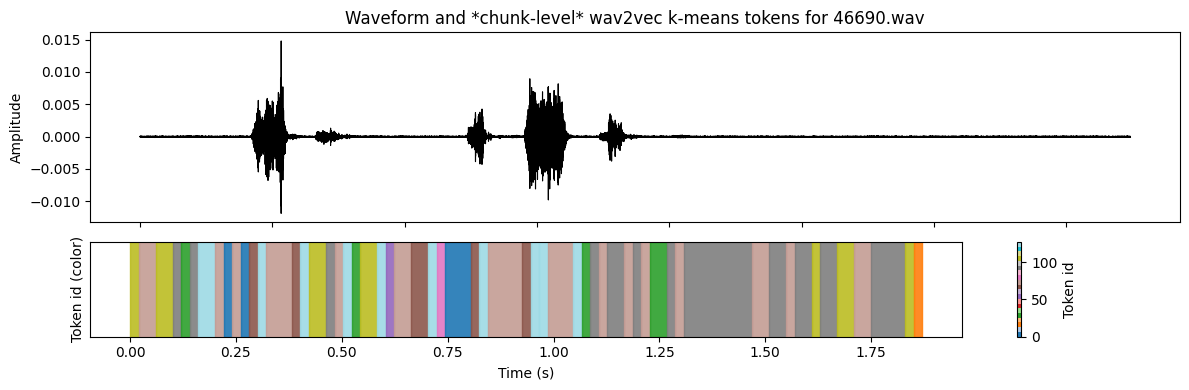

In [ ]:
from matplotlib import colors


def compress_tokens(tokens: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Run-length encode a 1D token sequence.

    Returns
    -------
    chunk_tokens : np.ndarray[int]
        Token id for each chunk.
    starts : np.ndarray[int]
        Start frame index (inclusive) for each chunk.
    ends : np.ndarray[int]
        End frame index (exclusive) for each chunk.
    """
    if len(tokens) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=int)

    changes = np.where(np.diff(tokens) != 0)[0] + 1
    boundaries = np.concatenate(([0], changes, [len(tokens)]))

    chunk_tokens = []
    starts = []
    ends = []
    for i in range(len(boundaries) - 1):
        s, e = int(boundaries[i]), int(boundaries[i + 1])
        chunk_tokens.append(int(tokens[s]))
        starts.append(s)
        ends.append(e)

    return np.asarray(chunk_tokens, dtype=int), np.asarray(starts, dtype=int), np.asarray(ends, dtype=int)


def plot_waveform_and_chunks(fn: str, max_duration: float | None = None) -> None:
    """Plot waveform and *chunk-level* tokens (run-length compressed) for one file."""
    wav_path = AUDIO_DIR / fn
    stem = Path(fn).stem
    token_path = TOKENS_DIR / f"w2v_kmeans_{stem}.npy"

    if not wav_path.exists():
        print(f"Missing audio: {wav_path}")
        return
    if not token_path.exists():
        print(f"Missing tokens: {token_path}")
        return

    # Load audio at 16 kHz (same as wav2vec2)
    wav_16k = load_audio_for_w2v(wav_path, target_sr=16_000)
    sr = 16_000
    if max_duration is not None:
        max_samples = int(max_duration * sr)
        wav_16k = wav_16k[:max_samples]

    tokens = np.load(token_path)
    chunk_tokens, starts, ends = compress_tokens(tokens)

    duration = len(wav_16k) / sr
    t_wave = np.linspace(0.0, duration, num=len(wav_16k))

    # Map frame indices to time
    t_starts = starts / len(tokens) * duration
    t_ends = ends / len(tokens) * duration

    print("\n" + "=" * 80)
    print(f"File: {fn}")
    print(f"Waveform samples: {len(wav_16k)} at {sr} Hz (duration ~{duration:.2f}s)")
    print(f"Frame-level tokens: {len(tokens)}")
    print(f"Chunk-level tokens after compression: {len(chunk_tokens)}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True,
                                   gridspec_kw={"height_ratios": [2, 1]})

    # Waveform
    ax1.plot(t_wave, wav_16k, color="black", linewidth=0.8)
    ax1.set_ylabel("Amplitude")
    ax1.set_title(f"Waveform and *chunk-level* wav2vec k-means tokens for {fn}")

    # Chunk-level tokens as colored spans
    cmap = plt.get_cmap("tab20")
    norm = colors.Normalize(vmin=0, vmax=N_CLUSTERS - 1)

    for t0, t1, tok in zip(t_starts, t_ends, chunk_tokens):
        ax2.axvspan(t0, t1, color=cmap(norm(tok)), alpha=0.9)

    ax2.set_yticks([])
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Token id (color)")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax2, label="Token id")

    plt.tight_layout()
    plt.show()


# visualize chunk-level tokens for a few example files
example_files = ann_small["File Name"].iloc[:3]
for fn in example_files:
    plot_waveform_and_chunks(fn, max_duration=5.0)
